<a href="https://colab.research.google.com/github/hridog00/RealOrNot/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=21493289dc4f7ba6d5ed2a216cdc5d568b9bd65f513717bed60c212cc200c902
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=b3641dddac7f1a44a3f56b170a1a64eba7ec9536815b220a19c8a908885f8340
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=ab1a3ec272e27185013761b31ac777105418cd5644dc4535fa2a854f9bebe5ed
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [0]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from bert import bert_tokenization
import numpy as np
from tensorflow.keras.utils import to_categorical

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512, learning_rate=0.0001):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    dense = Dense(1000, activation='relu')(clf_output)
    dense = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)

    dense = Dense(100, activation='relu')(dense)

    out = Dense(2, activation='softmax')(dense)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
import pandas as pd
import re

In [0]:
BASE_FOLDER = "/content/drive/My Drive/TFM/"

df =  pd.read_csv(BASE_FOLDER+"/resources/data/cleaned.csv")

In [7]:
df

,Unnamed: 0,keyword,text,target,cleaned_text
0,0,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,2,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,3,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...,...,...
7466,7604,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnew fallen powerlin glink tram updat fire...
7467,7605,NaN,on the flip side I'm at Walmart and there is a...,1,flip side im walmart bomb everyon evacu stay t...
7468,7606,NaN,Suicide bomber kills 15 in Saudi security site...,1,suicid bomber kill saudi secur site mosqu reut...
7469,7608,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home


In [0]:
data = df[['cleaned_text', 'target']]
data = data.dropna()

In [0]:
X = data['cleaned_text'].values
y = to_categorical(data['target'].values)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=False)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [14]:
model = build_model(bert_layer, max_len=160,learning_rate=0.0001)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 108310273   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
train_input = bert_encode(X_train, tokenizer, max_len=160)
train_labels = y_train
test_input = bert_encode(X_test, tokenizer, max_len=160)
test_labels = y_test

In [0]:
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=40,
    callbacks=[checkpoint],
    batch_size=500
)

Epoch 1/40
8/8 [==============================] - 57s 7s/step - loss: 1.3270 - accuracy: 0.5839 - val_loss: 1.2978 - val_accuracy: 0.6590
Epoch 2/40
8/8 [==============================] - 55s 7s/step - loss: 1.2646 - accuracy: 0.6819 - val_loss: 1.2467 - val_accuracy: 0.7010
Epoch 3/40
8/8 [==============================] - 55s 7s/step - loss: 1.2163 - accuracy: 0.7149 - val_loss: 1.2163 - val_accuracy: 0.7040
Epoch 4/40
8/8 [==============================] - 55s 7s/step - loss: 1.1819 - accuracy: 0.7209 - val_loss: 1.1826 - val_accuracy: 0.7160
Epoch 5/40
8/8 [==============================] - 55s 7s/step - loss: 1.1477 - accuracy: 0.7394 - val_loss: 1.1565 - val_accuracy: 0.7270
Epoch 6/40
8/8 [==============================] - ETA: 0s - loss: 1.1186 - accuracy: 0.7444

In [0]:
history = train_history

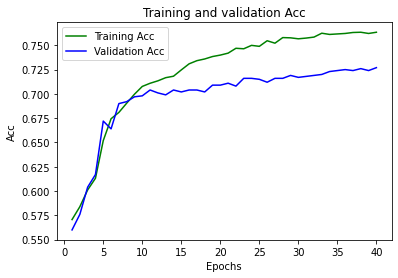

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

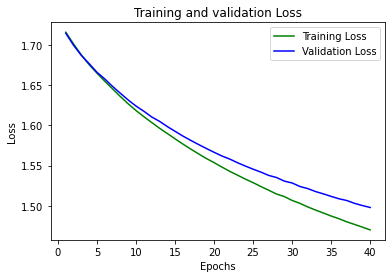

In [86]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()